In [1]:
from matplotlib import pyplot,cm
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
import numba
from numba import jit

In [2]:
ni=51
nj=51
dx=2*pi/(ni-1)
dy=2*pi/(nj-1)
x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
xu=numpy.linspace(0,2*pi+dx,ni+1)
yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
yv=numpy.linspace(0,2*pi+dy,nj+1)

X,Y=numpy.meshgrid(x,y)
Xu,Yu=numpy.meshgrid(xu,yu)
Xv,Yv=numpy.meshgrid(xv,yv)

u0=-numpy.cos(Xu)*numpy.sin(Yu)
v0=numpy.sin(Xv)*numpy.cos(Yv)
p0=-(numpy.cos(2*X)+numpy.cos(2*Y))/4
omega0=numpy.zeros((nj+1,ni+1))
for i in range(ni):
    for j in range(nj):
        omega0[j,i]=(v0[j,i+1]-v0[j,i])/dx-(u0[j+1,i]-u0[j,i])/dy

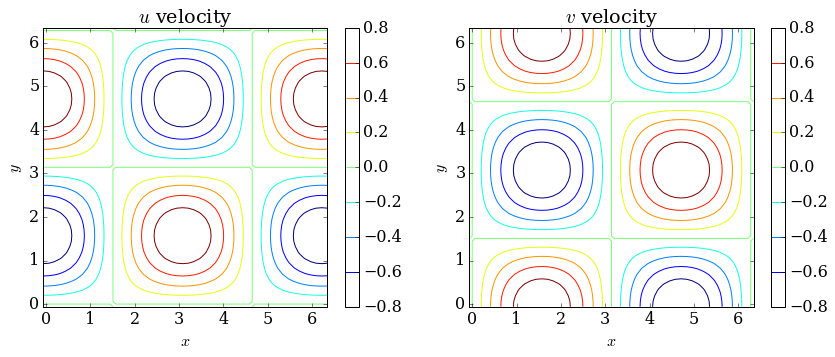

In [3]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(X,Y,u0,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity');

pyplot.subplot(122)
pyplot.contour(X,Y,v0,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

In [ ]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],omega0[1:-1,1:-1],10)
pyplot.colorbar()
pyplot.quiver(X[1:-1:3,1:-1:3],Y[1:-1:3,1:-1:3],u0[1:-1:3,1:-1:3],v0[1:-1:3,1:-1:3],scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('vorticity and velocity vectors');

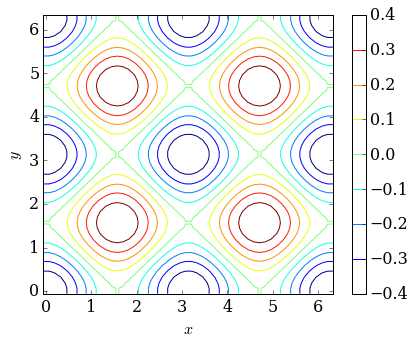

In [4]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,p0,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [5]:
def uex(t,X,Y):
    return -numpy.exp(-2*t)*numpy.cos(X)*numpy.sin(Y)

def vex(t,X,Y):
    return numpy.exp(-2*t)*numpy.sin(X)*numpy.cos(Y)

def pex(t,X,Y):
    return -numpy.exp(-4*t)/4.*(numpy.cos(2*X)+numpy.cos(2*Y))

In [6]:
@jit
def Fc1(u,v,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if i==0 and j==0:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,ni-2])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[nj-2,i])*(v[nj-2,i+1]+v[nj-2,i]))/4/dy
    elif i==0 and j==nj:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,ni-2])**2)/4/dx-\
            ((u[j,i]+u[2,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,i+1]+v[j-1,i]))/4/dy
    elif i==ni and j==0:
        F=-((u[j,i]+u[j,2])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,2]+v[j,i])-\
            (u[j,i]+u[nj-2,i])*(v[nj-2,2]+v[nj-2,i]))/4/dy
    elif i==ni and j==nj:
        F=-((u[j,i]+u[j,2])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[2,i])*(v[j,2]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,2]+v[j-1,i]))/4/dy
    elif j==0:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[nj-2,i])*(v[nj-2,i+1]+v[nj-2,i]))/4/dy
    elif i==0:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,ni-2])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,i+1]+v[j-1,i]))/4/dy
    elif j==nj:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[2,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,i+1]+v[j-1,i]))/4/dy
    elif i==ni:
        F=-((u[j,i]+u[j,2])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,2]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,2]+v[j-1,i]))/4/dy
    else:
        F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
            ((u[j,i]+u[j+1,i])*(v[j,i+1]+v[j,i])-\
            (u[j,i]+u[j-1,i])*(v[j-1,i+1]+v[j-1,i]))/4/dy    
    return F

In [7]:
@jit
def Fc2(u,v,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if i==0 and j==0:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[j+1,ni-2]+u[j,ni-2])*(v[j,i]+v[j,ni-2]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[nj-2,i])**2)/4/dy
    elif i==0 and j==nj:
        F=-((u[2,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[2,ni-2]+u[j,ni-2])*(v[j,i]+v[j,ni-2]))/4/dx-\
            ((v[j,i]+v[2,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    elif i==ni and j==0:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,2])-\
            (u[j+1,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[nj-2,i])**2)/4/dy
    elif i==ni and j==nj:
        F=-((u[2,i]+u[j,i])*(v[j,i]+v[j,2])-\
            (u[2,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[2,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    elif j==0:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[j+1,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[nj-2,i])**2)/4/dy
    elif i==0:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[j+1,ni-2]+u[j,ni-2])*(v[j,i]+v[j,ni-2]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    elif j==nj:
        F=-((u[2,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[2,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[2,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    elif i==ni:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,2])-\
            (u[j+1,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    else:
        F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
            (u[j+1,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
            ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    return F

In [8]:
@jit
def Fv1(u,v,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if i==0 and j==0:
        F=(u[j,i+1]-2*u[j,i]+u[j,ni-2])/dx**2+(u[j+1,i]-2*u[j,i]+u[nj-2,i])/dy**2
    elif i==0 and j==nj:
        F=(u[j,i+1]-2*u[j,i]+u[j,ni-2])/dx**2+(u[2,i]-2*u[j,i]+u[j-1,i])/dy**2
    elif i==ni and j==0:
        F=(u[j,2]-2*u[j,i]+u[j,i-1])/dx**2+(u[j+1,i]-2*u[j,i]+u[nj-2,i])/dy**2
    elif i==ni and j==nj:
        F=(u[j,2]-2*u[j,i]+u[j,i-1])/dx**2+(u[2,i]-2*u[j,i]+u[j-1,i])/dy**2
    elif j==0:
        F=(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2+(u[j+1,i]-2*u[j,i]+u[nj-2,i])/dy**2
    elif i==0:
        F=(u[j,i+1]-2*u[j,i]+u[j,ni-2])/dx**2+(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2
    elif j==nj:
        F=(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2+(u[2,i]-2*u[j,i]+u[j-1,i])/dy**2
    elif i==ni:
        F=(u[j,2]-2*u[j,i]+u[j,i-1])/dx**2+(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2
    else:
        F=(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2+(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2
    return F

In [9]:
@jit
def Fv2(u,v,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if i==0 and j==0:
        F=(v[j,i+1]-2*v[j,i]+v[j,ni-2])/dx**2+(v[j+1,i]-2*v[j,i]+v[nj-2,i])/dy**2
    elif i==0 and j==nj:
        F=(v[j,i+1]-2*v[j,i]+v[j,ni-2])/dx**2+(v[2,i]-2*v[j,i]+v[j-1,i])/dy**2
    elif i==ni and j==0:
        F=(v[j,2]-2*v[j,i]+v[j,i-1])/dx**2+(v[j+1,i]-2*v[j,i]+v[nj-2,i])/dy**2
    elif i==ni and j==nj:
        F=(v[j,2]-2*v[j,i]+v[j,i-1])/dx**2+(v[2,i]-2*v[j,i]+v[j-1,i])/dy**2
    elif j==0:
        F=(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2+(v[j+1,i]-2*v[j,i]+v[nj-2,i])/dy**2
    elif i==0:
        F=(v[j,i+1]-2*v[j,i]+v[j,ni-2])/dx**2+(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2
    elif j==nj:
        F=(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2+(v[2,i]-2*v[j,i]+v[j-1,i])/dy**2
    elif i==ni:
        F=(v[j,2]-2*v[j,i]+v[j,i-1])/dx**2+(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2
    else:
        F=(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2+(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2
    return F

In [10]:
@jit
def Fp1(p,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if i==0:
        F=-(p[j,i+1]-p[j,ni-2])/2/dx
    elif i==ni:
        F=-(p[j,2]-p[j,i-1])/2/dx
    else:
        F=-(p[j,i+1]-p[j,i-1])/2/dx
    return F

In [11]:
@jit
def Fp2(p,i,j,dx,dy):
    nj,ni=numpy.shape(u)-numpy.array((1,1))
    if j==0:
        F=-(p[j+1,i]-p[nj-2,i])/2/dy
    elif j==nj:
        F=-(p[2,i]-p[j-1,i])/2/dy
    else:
        F=-(p[j+1,i]-p[j-1,i])/2/dy
    return F

In [12]:
@jit
def poisson(f,N,omega,t):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    err=numpy.zeros(numpy.shape(f))
    
    p_ex=pex(t,X,Y)
    res_max=1e3
    n=0
    while n<N:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=p[1,:]
        p[nj,:]=p[nj-1,:]
        p[:,0]=p[:,1]
        p[:,ni]=p[:,ni-1]
        n+=1
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
        
    for j in range(nj+1):
        for i in range(ni+1):
            err[j,i]=numpy.abs(p[j,i]-p_ex[j,i])
    err_max=numpy.max(err)
    
    return p,res_max,err_max

In [13]:
dt=0.005
T=2
nt=int(T/dt)
t=0
u=u0.copy()
v=v0.copy()
p=p0.copy()

In [14]:
G1=numpy.zeros((nj+1,ni+1))
G2=numpy.zeros((nj+1,ni+1))
w1=numpy.zeros((nj+1,ni+1))
w2=numpy.zeros((nj+1,ni+1))
f=numpy.zeros((nj+1,ni+1))
for j in range(nj+1):
    for i in range(ni+1):
        G1[j,i]=Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
        G2[j,i]=Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
        w1[j,i]=u[j,i]+dt*G1[j,i]/3
        w2[j,i]=v[j,i]+dt*G2[j,i]/3


In [15]:
for j in range(nj+1):
    for i in range(ni+1):
        if i==0 and j==0:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==0 and j==nj:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==ni and j==0:
            f[j,i]=3./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==ni and j==nj:
            f[j,i]=3./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif j==0:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif j==nj:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==0:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        elif i==ni:
            f[j,i]=3./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        else:
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)

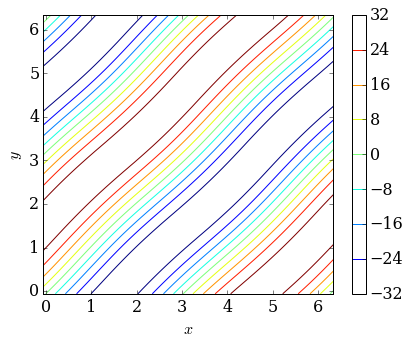

In [16]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,f,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [17]:
p,res,err=poisson(f,10000,1.4,t+dt/3)
print(res,err)

2.9949376312288223e-12 37.3841434245


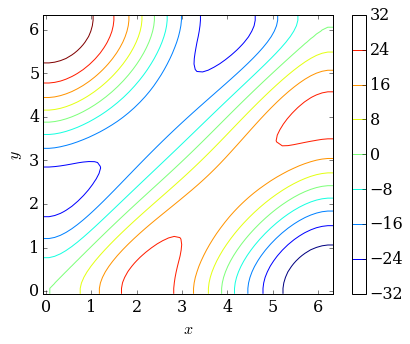

In [18]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,p,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [19]:
for j in range(nj+1):
    for i in range(ni+1):
        u[j,i]=w1[j,i]+dt/3*Fp1(p,i,j,dx,dy)
        v[j,i]=w2[j,i]+dt/3*Fp2(p,i,j,dx,dy)
        
u[0,:]=-u[1,:]
u[-1,:]=-u[-2,:]
u[:,0]=u[:,-2]
u[:,-1]=u[:,1]

v[0,:]=v[-2,:]
v[-1,:]=v[1,:]
v[:,0]=-v[:,1]
v[:,-1]=-v[:,-2]

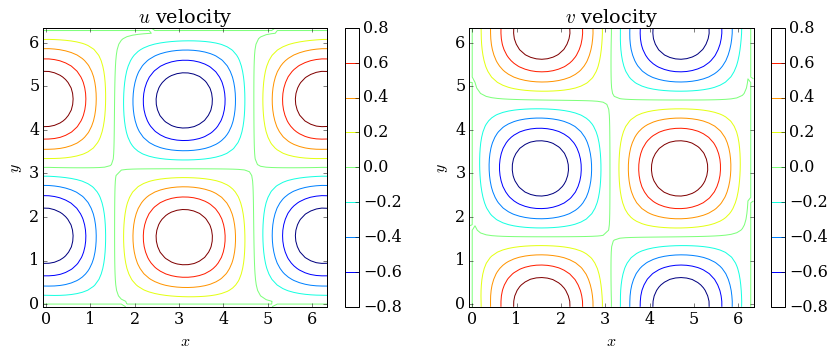

In [21]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(X,Y,u,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity');

pyplot.subplot(122)
pyplot.contour(X,Y,v,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

In [22]:
for j in range(nj+1):
    for i in range(ni+1):
        G1[j,i]=-5./9*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
        G2[j,i]=-5./9*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
        w1[j,i]=u[j,i]+dt*15./16*G1[j,i]
        w2[j,i]=v[j,i]+dt*15./16*G2[j,i]

In [23]:
for j in range(nj+1):
    for i in range(ni+1):
        if i==0 and j==0:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==0 and j==nj:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==ni and j==0:
            f[j,i]=12./5/dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==ni and j==nj:
            f[j,i]=12./5/dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif j==0:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif j==nj:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==0:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        elif i==ni:
            f[j,i]=12./5/dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        else:
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)

In [24]:
p,res,err=poisson(f,10000,1.4,t+3*dt/4)
print(res,err)

1.213473765915296e-13 1.55107879674


In [25]:
for j in range(nj+1):
    for i in range(ni+1):
        u[j,i]=w1[j,i]+5./12*dt*Fp1(p,i,j,dx,dy)
        v[j,i]=w2[j,i]+5./12*dt*Fp2(p,i,j,dx,dy)
u[0,:]=-u[1,:]
u[-1,:]=-u[-2,:]
u[:,0]=u[:,-2]
u[:,-1]=u[:,1]

v[0,:]=v[-2,:]
v[-1,:]=v[1,:]
v[:,0]=-v[:,1]
v[:,-1]=-v[:,-2]

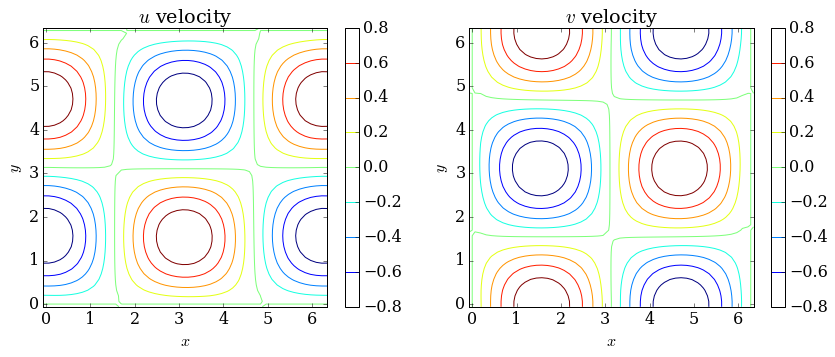

In [26]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(X,Y,u,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity');

pyplot.subplot(122)
pyplot.contour(X,Y,v,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

In [27]:
for j in range(nj+1):
    for i in range(ni+1):
        G1[j,i]=-153./128*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
        G2[j,i]=-153./128*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
        w1[j,i]=u[j,i]+8./15*dt*G1[j,i]
        w2[j,i]=v[j,i]+8./15*dt*G2[j,i]

In [28]:
for j in range(nj+1):
    for i in range(ni+1):
        if i==0 and j==0:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==0 and j==nj:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==ni and j==0:
            f[j,i]=4./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif i==ni and j==nj:
            f[j,i]=4./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif j==0:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[nj-2,i])/2/dy)
        elif j==nj:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[2,i]-w2[j-1,i])/2/dy)
        elif i==0:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,ni-2])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        elif i==ni:
            f[j,i]=4./dt*((w1[j,2]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
        else:
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)

In [29]:
p,res,err=poisson(f,10000,1.4,t+dt)
print(res,err)

1.5221157667610896e-13 2.18069702981


In [30]:
for j in range(nj+1):
    for i in range(ni+1):
        u[j,i]=w1[j,i]+dt/4*Fp1(p,i,j,dx,dy)
        v[j,i]=w2[j,i]+dt/4*Fp2(p,i,j,dx,dy)
        
u[0,:]=-u[1,:]
u[-1,:]=-u[-2,:]
u[:,0]=u[:,-2]
u[:,-1]=u[:,1]

v[0,:]=v[-2,:]
v[-1,:]=v[1,:]
v[:,0]=-v[:,1]
v[:,-1]=-v[:,-2]

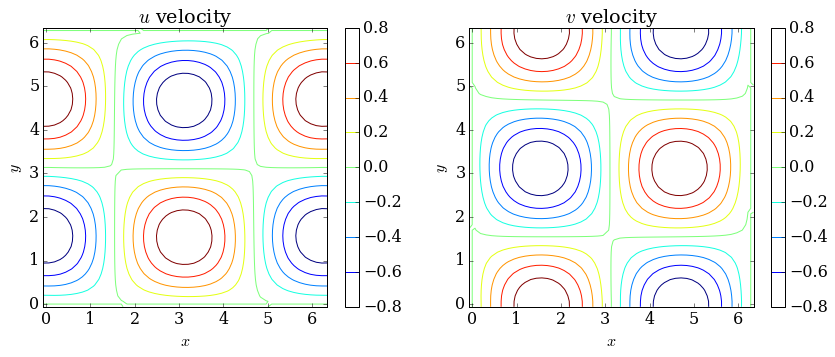

In [31]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(X,Y,u,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity');

pyplot.subplot(122)
pyplot.contour(X,Y,v,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

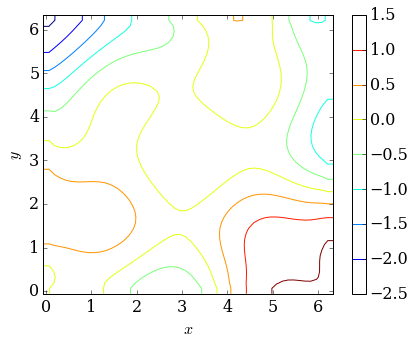

In [32]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,p,10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [ ]:
p=poisson(f,1e-6,1.8)
for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+dt/3*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+dt/3*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-5./9*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
            G2[j,i]=-5./9*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
            w1[j,i]=u[j,i]+dt*15./16*G1[j,i]
            w2[j,i]=v[j,i]+dt*15./16*G2[j,i]
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+5./12*dt*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+5./12*dt*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-153./128*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
            G2[j,i]=-153./128*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
            w1[j,i]=u[j,i]+8./15*dt*G1[j,i]
            w2[j,i]=v[j,i]+8./15*dt*G2[j,i]
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+dt/4*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+dt/4*Fp2(p,i,j,dx,dy)
    t+=1

In [ ]:
pyplot.figure(figsize=(8,6))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],omega[1:-1,1:-1],10)
pyplot.colorbar();
pyplot.quiver(X[1:-1:3,1:-1:3],Y[1:-1:3,1:-1:3],ut[1:-1:3,1:-1:3],vt[1:-1:3,1:-1:3],scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [ ]:

omega=numpy.zeros((nj+1,ni+1))
for i in range(1,ni-1):
    for j in range(1,nj-1):
        omega[j,i]=(vt[j,i+1]-vt[j,i-1])/2/dx-(ut[j+1,i]-ut[j-1,i])/2/dy

In [ ]:
@jit
def compute(u,v,dx,dy):
    G1=numpy.zeros((nj+1,ni+1))
    G2=numpy.zeros((nj+1,ni+1))
    w1=numpy.zeros((nj+1,ni+1))
    w2=numpy.zeros((nj+1,ni+1))
    f=numpy.zeros((nj+1,ni+1))
    un=u.copy()
    vn=v.copy()
    for j in range(1,nj):
        for i in range(1,ni):
            G1[j,i]=Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+dt*G1[j,i]/3
            w2[j,i]=vn[j,i]+dt*G2[j,i]/3
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+dt/3*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+dt/3*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-5./9*G1[j,i]+Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=-5./9*G2[j,i]+Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+dt*15./16*G1[j,i]
            w2[j,i]=vn[j,i]+dt*15./16*G2[j,i]
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+5./12*dt*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+5./12*dt*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-153./128*G1[j,i]+Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=-153./128*G2[j,i]+Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+8./15*dt*G1[j,i]
            w2[j,i]=vn[j,i]+8./15*dt*G2[j,i]
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+dt/4*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+dt/4*Fp2(p,i,j,dx,dy)
    
    return un,vn

In [ ]:
omega=numpy.zeros((nj+1,ni+1))
for i in range(1,ni-1):
    for j in range(1,nj-1):
        omega0[j,i]=(v[j,i+1]-v[j,i-1])/2/dx-(u[j+1,i]-u[j-1,i])/2/dy